# Import libraries

In [364]:
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import os

# v0.2 imports
import mplfinance as fplt
import matplotlib.pyplot as plt

# v0.4 imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, GRU, SimpleRNN, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [365]:
# set seed to get stable results in training/testing run
np.random.seed(314)

In [366]:
def load_data(download, ticker, TEST_START='2020-01-01', TEST_END='2023-01-01', scale=True, shuffle=True, dropNaN=True, split_by_ratio=True, split_by_date=False, split_date=None, test_size=0.2, feature_columns=["adjclose", "volume", "open", "high", "low"], n_steps=30):
    """
    Loads data from yahoo finance, then scaling, shuffle, and normalization.
    :param ticker: (str/pd.DataFrame), the ticker you want to load, like META, AAPL,...
    :param TEST_START: str, the start date of the test data (format: "YYYY-MM-DD")
    :param TEST_END: str, the end date of the test data (format: "YYYY-MM-DD")
    :param scale: whether to scale prices between 0 and 1, default is True
    :param shuffle: bool, whether to shuffle the dataset (both training and testing), default is True
    :param dropNaN: bool, whether to drop NaN values, default is True
    :param split_by_date: bool, whether to split the data into training and testing by date, default is True
    :param test_size: ratio of test data to train data, default is 0.2 (80% for training and 20% for testing)
    :param feature_columns: the list of features to feed into the model, default is everything grabbed from yahoo_fin
    :return: 
    """
    
    # ------------------------------------------------------------------------------------------------#
    # Ticket to csv file, put it into folder dataset
    if download:
        ticker_data_filename = os.path.join("dataset", f"{ticker}_{TEST_START}_{TEST_END}.csv") 
        ## a, see if ticker is already a loaded stock from yahoo finance
        if os.path.exists(ticker_data_filename):
            print(f'Loading data from {ticker_data_filename}')
            # read csv file, take date column as index
            df = pd.read_csv(ticker_data_filename, index_col=0)
        else:
            print(f'Downloading data for {ticker} from yahoo finance')
            if not os.path.exists("dataset"):
                os.makedirs("dataset")
            # download data from yahoo finance before assign into dataframe
            df = si.get_data(ticker, TEST_START, TEST_END)
             ## d, Store the download data locally for future use
            df.to_csv(ticker_data_filename)
    # ------------------------------------------------------------------------------------------------#



    # ------------------------------------------------------------------------------------------------#
    ## b, Allow you to deal with the NaN issue in the data

    # drop NaNs or fill nan with mean
    if dropNaN:
        df.dropna(inplace=True)
    else:
        df.fillna(df.mean())
    # ------------------------------------------------------------------------------------------------#
    
    # this will contain all the elements we want to return from this function
    result = {'df': df.copy()}

    # we will also return the original dataframe itself

    # ------------------------------------------------------------------------------------------------#
    ## c, use different methods to split the data into train/test data; 
    # e.g. you can split it according to some specified ratio of train/test and you can specify to split it by date or randomly
    if split_by_ratio:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(df))
        
        # :train_samples means from the beginning to train_samples, and train_samples: means from train_samples to the end
        result['df_train'] = df[:train_samples]
        result['df_test'] = df[train_samples:]
        
    elif split_by_date and split_date is not None:
        # Convert split_date to a datetime object
        split_date = pd.to_datetime(split_date)
        
        # Split by date on the index
        result['df_train'] = df[df.index <= split_date]  # Take data from the start to split_date
        result['df_test'] = df[df.index > split_date]  # Take data after split_date to the end

    else:
        # If neither split by ratio nor split by date, randomly split the dataset
        result['df_train'], result['df_test'] = train_test_split(df, test_size=test_size, shuffle=shuffle)
    # ------------------------------------------------------------------------------------------------#



   
    # # ------------------------------------------------------------------------------------------------#
    # ## e, scale the feature columns and store the scalers in data structure 
    # if scale:
    #     result['column_scaler'] = df[feature_columns]
    #     scale_min_max = MinMaxScaler(feature_range=(0, 1))
    #     result['column_scaler'] = scale_min_max.fit_transform(result['column_scaler'][['close']])
    #     # target = result['column_scaler'][['close']]
    #     # print(target)
    #     X, y = create_sequences(result['column_scaler'], n_steps)
    #     X = X.reshape((X.shape[0], X.shape[1], 1))
    #     result['X_train'], result['X_test'], result['y_train'], result['y_test'] = train_test_split(X, y, test_size=0.2, shuffle=False)
    #     print(result['X_train'].shape, result['X_test'].shape)
    #     print(result['y_test'].shape)
    #     result['y_test_scaled'] = scale_min_max.inverse_transform(result['y_test'].reshape(-1, 1))
    #     
    # # ------------------------------------------------------------------------------------------------#
    
    return result

In [367]:
# Able to download
DOWNLOAD = True

# Amazon stock market
TICKER = "AMZN"

# Start and End date to read:
TEST_START = '2020-01-01'
TEST_END = '2023-01-01'

# the days lookback
N_STEPS = 30

# whether to scale feature columns & output price as well
SCALE = True

# lookup step, 1 is the next day
LOOKUP_STEP = 15

# drop rows with NaN values
DROP_NAN = True

# whether to shuffle the dataset
SHUFFLE = True

# whether to split the training/testing set by date
SPLIT_BY_DATE = False

# test radio size, 0.2 is 20%
TEST_SIZE = 0.2

# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low", "close"]

In [368]:
data = load_data(download=DOWNLOAD, ticker=TICKER, TEST_START=TEST_START, TEST_END=TEST_END, scale=SCALE, dropNaN=True,
          shuffle=SHUFFLE, split_by_date=SPLIT_BY_DATE, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS, n_steps=N_STEPS)

Loading data from dataset/AMZN_2020-01-01_2023-01-01.csv


In [369]:
data["df"].head()

,open,high,low,close,adjclose,volume,ticker
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,AMZN
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,AMZN
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,AMZN
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,AMZN
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000,AMZN


In [370]:
data["column_scaler"]

KeyError: 'column_scaler'

# Improve to v0.2: Include charts

In [ ]:
def display_stock_candlestick(data, n=1, title='Candlestick chart'):
    """
    Write a function to display stock market financial data using candlestick chart
    :param data: pd.DataFrame, stock market data with columns ['Open', 'High', 'Low', 'Close', 'Volume']
    :param n: trading days
    :param title: show the chart title
    :return: 
    """
    # check if index column is datetime
    if not isinstance(data.index, pd.DataFrame):
        data.index = pd.to_datetime(data.index)
    
    # allow each candle stick to express the data of `n` trading days
    if n >= 1:
        # Resample the data to aggregate over 'n' trading days
        data = data.resample(f'{n}D').agg({
            'open' : 'first',
            'high' : 'max',
            'low' : 'min',
            'close' : 'last',
            'volume' : 'sum'
        }).dropna()

    # plot the candlestick chart
    fplt.plot(
        data,
        type='candle',
        style='charles',
        title=title,
        ylabel='Price ($)',
        volume=True,
        ylabel_lower='Shares\nTraded'
    )


In [ ]:
display_stock_candlestick(data["df"], n=1, title='1-day trading candlestick chart')

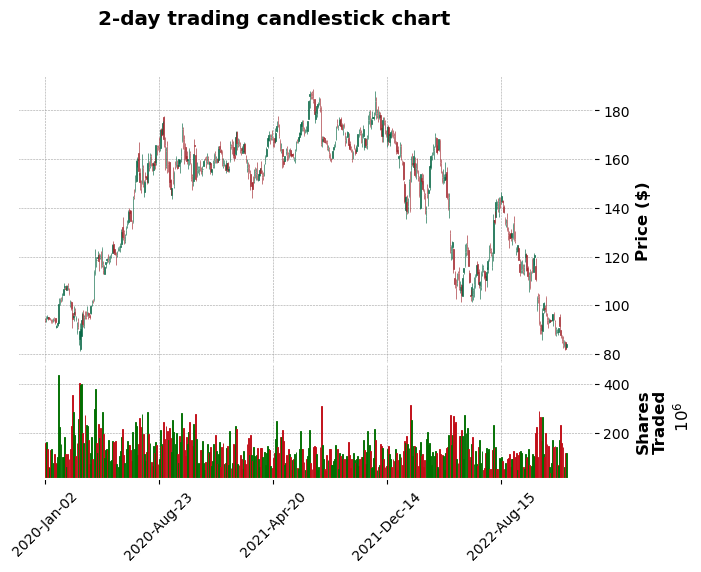

In [371]:
display_stock_candlestick(data["df"], n=2, title='2-day trading candlestick chart')

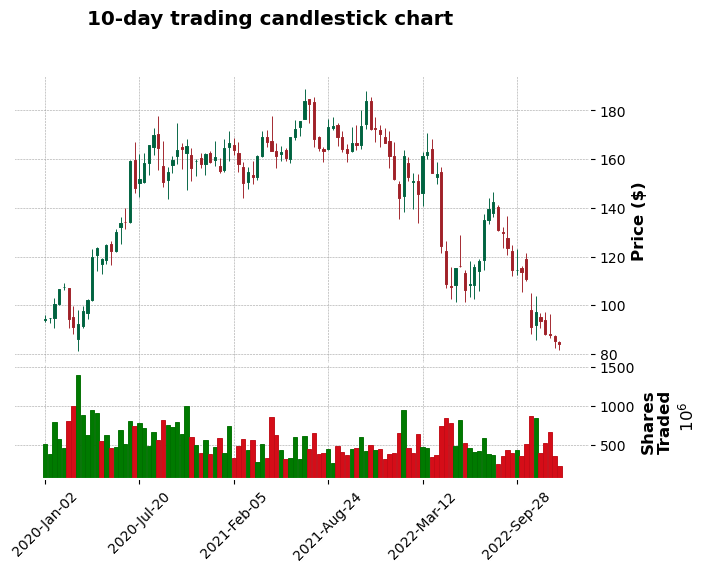

In [372]:
display_stock_candlestick(data["df"], n=10, title='10-day trading candlestick chart')

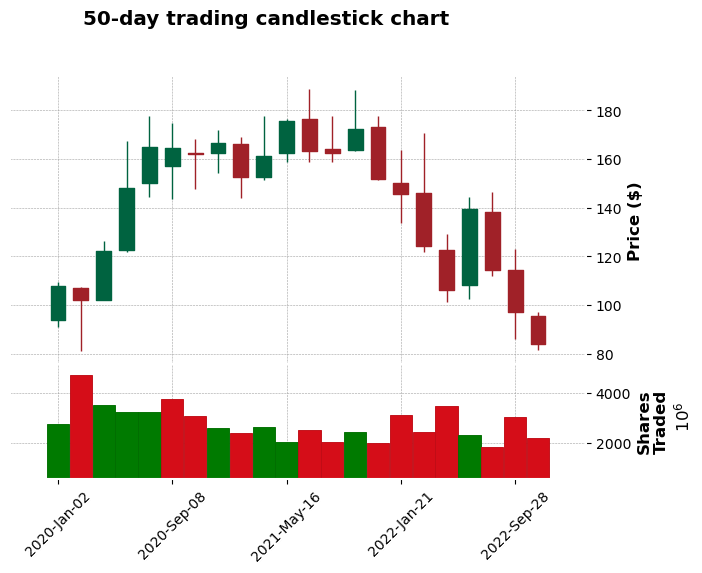

In [373]:
display_stock_candlestick(data["df"], n=50, title='50-day trading candlestick chart')

# Write a function to display stock market financial data using boxplot chart. 
This is particularly useful when you are trying to display your data for a moving window of `n`
consecutive trading days. Again, feel free to use online resources that teach you how to
this but you need to add comments to explain your codes and the parameters you use.

In [374]:
def plot_stock_boxplot(data, columns, figsize=(10, 7), title='Boxplot for Stock Data'):
    data_show = data[columns]
    plt.figure(figsize=figsize)
    plt.boxplot(data_show.values, labels=columns)
    plt.title(title, fontsize=16)
    plt.ylabel('Values')
    plt.show()


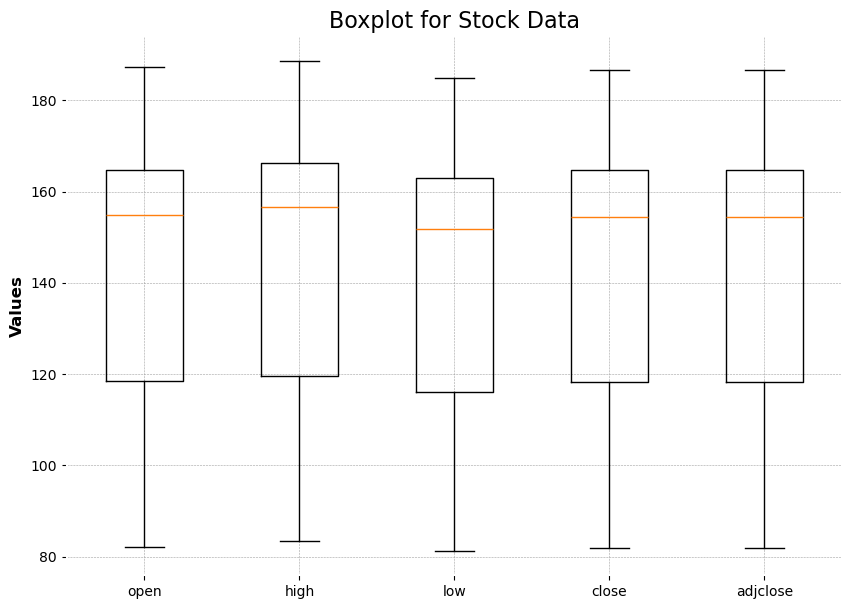

In [375]:
columns = ['open', 'high', 'low', 'close', 'adjclose']
plot_stock_boxplot(data["df"],columns)

In [376]:
def plot_moving_window_boxplot(data, columns, n, figsize=(10, 7), title='Boxplot for Stock Data'):
    """
    This function generates a boxplot for the specified stock data over a moving window of n days.
    
    Parameters:
    data (DataFrame): The entire dataset containing stock data.
    columns (list): The list of column names for which the boxplot will be generated (e.g., 'open', 'high', 'low').
    n (int): The window size (number of days) to use for the boxplot. Must be between 1 and the number of rows in the data.
    figsize (tuple): Optional; the size of the plot (default is (10, 7)).
    title (str): the title of the boxplot (default is 'Boxplot for Stock Data').
    """
    
    # Check if the window size 'n' is within valid bounds.
    if n < 1 or n > len(data):
        raise ValueError(f"The window size n must be >= 1 and <= the number of rows: {len(data)} in the data.")
    
    # Extract the first 'n' rows of data for the selected columns to create the moving window.
    window_data = data[columns].iloc[:n]

    # Create a new figure with the specified size for the boxplot.
    plt.figure(figsize=figsize)
    
    # Generate a boxplot using the values of the selected columns within the moving window.
    plt.boxplot(window_data.values, labels=columns)
    
    # Set the title of the boxplot, incorporating the window size 'n'.
    plt.title(f'{title}  with {n} days)', fontsize=16)
    
    # Label the y-axis as 'Values'.
    plt.ylabel('Values')
    
    # Display the plot.
    plt.show()

# Example usage:
columns = ['open', 'high', 'low', 'close', 'adjclose']

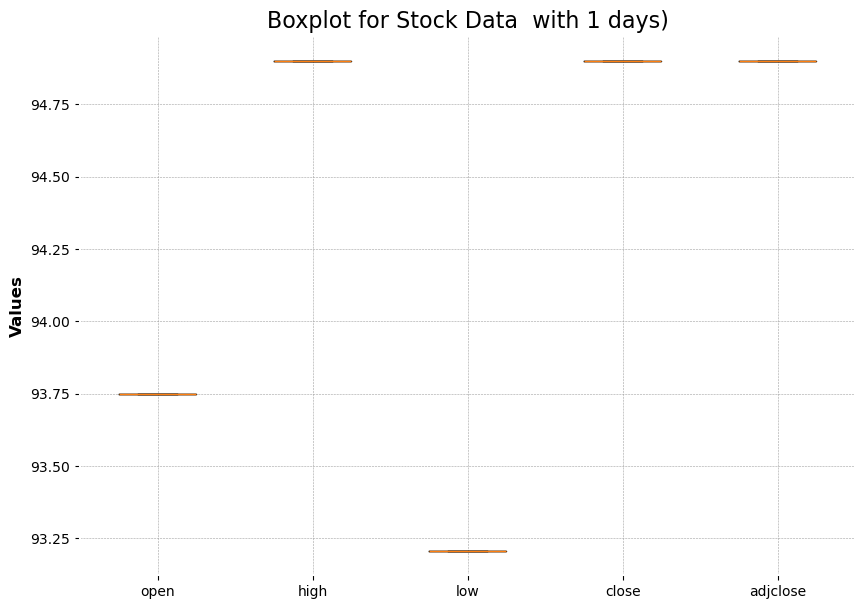

In [377]:
plot_moving_window_boxplot(data["df"], columns, n=1)

# v0.3: Machine Learning 1

Write a function that takes as input several parameters including the number of layers, the
size of each layer, the layer name and return a Deep Learning model. 

Again, our reference project (`P1`) will give you an example of how this can be done. 

You can reuse this example, extend it, and most importantly, explain in detail all the code in your program

In [378]:
target = data["df"][['close']]

target

,close
2020-01-02,94.900497
2020-01-03,93.748497
2020-01-06,95.143997
2020-01-07,95.343002
2020-01-08,94.598503
...,...
2022-12-23,85.250000
2022-12-27,83.040001
2022-12-28,81.820000
2022-12-29,84.180000


In [379]:
from sklearn.preprocessing import MinMaxScaler

def create_sequences(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(target)

scaled_data

array([[0.1248729 ],
       [0.11387533],
       [0.12719746],
       [0.12909727],
       [0.12198991],
       [0.12632397],
       [0.11778462],
       [0.12167009],
       [0.11123575],
       [0.10769398],
       [0.11529304],
       [0.10898278],
       [0.12200418],
       [0.11983715],
       [0.11846241],
       [0.10751263],
       [0.09161771],
       [0.10350785],
       [0.10577517],
       [0.1118276 ],
       [0.17771751],
       [0.17556002],
       [0.19726396],
       [0.1925862 ],
       [0.19753126],
       [0.21139754],
       [0.23747385],
       [0.24553584],
       [0.24992722],
       [0.24509192],
       [0.23793205],
       [0.24786041],
       [0.25480549],
       [0.24663367],
       [0.21936412],
       [0.17798962],
       [0.16054341],
       [0.16381307],
       [0.11832876],
       [0.11806627],
       [0.15157448],
       [0.13011396],
       [0.16201829],
       [0.13729291],
       [0.12634305],
       [0.07838152],
       [0.12191831],
       [0.088

In [380]:
n_steps = 30 # the days lookback
X, y = create_sequences(scaled_data, n_steps)

X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, X_test.shape

((580, 30, 1), (145, 30, 1))

In [381]:
y_test.shape

(145,)

In [382]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [383]:
def build_custom_model(layer_type='LSTM', input_shape=(30, 1), layer_sizes=[50], num_layers=1, dropout=0.2):
    """
    Function to build a custom deep learning model based on provided parameters.
    
    Parameters:
    layer_type: str - The type of recurrent layer (e.g., 'LSTM', 'GRU', 'RNN').
    input_shape: tuple - Shape of the input data (timesteps, features).
    layer_sizes: list - A list containing the number of units for each layer.
    num_layers: int - The number of recurrent layers to be added to the model.
    dropout: float - Dropout rate to prevent overfitting.
    
    Returns:
    model: A compiled Keras model.
    """
    model = Sequential()
    # Add the Input layer
    model.add(Input(shape=input_shape))
    
    # Add recurrent layers based on layer type
    for i in range(num_layers):
        units = layer_sizes[i] if i < len(layer_sizes) else layer_sizes[-1]  # If more layers than sizes, repeat the last size
        
        if layer_type == 'LSTM':
            model.add(LSTM(units, return_sequences=(i < num_layers - 1)))
        elif layer_type == 'GRU':
            model.add(GRU(units, return_sequences=(i < num_layers - 1)))
        elif layer_type == 'RNN':
            model.add(SimpleRNN(units, return_sequences=(i < num_layers - 1)))
        
        # Add dropout after each recurrent layer to prevent overfitting
        model.add(Dropout(dropout))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


In [384]:
def plot_predict(test, predictions, title='Predicted vs Actual Values'):
    plt.figure(figsize=(10, 6))
    plt.plot(test, label='Actual Values', color='blue', linestyle='--')
    plt.plot(predictions, label='Predicted Values', color='red')

    # Adding title and labels
    plt.title(title)
    plt.xlabel('Observation Number')
    plt.ylabel('Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [385]:
epochs = 50
batch_size = 32

Use the above function to experiment with different DL networks (e.g., LSTM, RNN, GRU,
etc.) and with different hyperparameter configurations (e.g. different numbers of layers and
layer sizes, number of epochs, batch sizes, etc.)

RNN

In [386]:
model_rnn1 = build_custom_model(layer_type='RNN', input_shape=(30, 1), layer_sizes=[200], num_layers=2, dropout=0.2)
history1 = model_rnn1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
19/19 [==============================] - 1s 20ms/step - loss: 0.3853 - val_loss: 0.0127
Epoch 2/50
19/19 [==============================] - 0s 15ms/step - loss: 0.1204 - val_loss: 0.0561
Epoch 3/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0881 - val_loss: 0.0144
Epoch 4/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0709 - val_loss: 0.0072
Epoch 5/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0524 - val_loss: 0.0074
Epoch 6/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0546 - val_loss: 0.0174
Epoch 7/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0475 - val_loss: 0.0176
Epoch 8/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0181 - val_loss: 0.0034
Epoch 9/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0169 - val_loss: 0.0052
Epoch 10/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0181 - val_loss: 0.0056
Epoch 11/

5/5 [==============================] - 0s 4ms/step
23.25842003606797
4.005665062213766


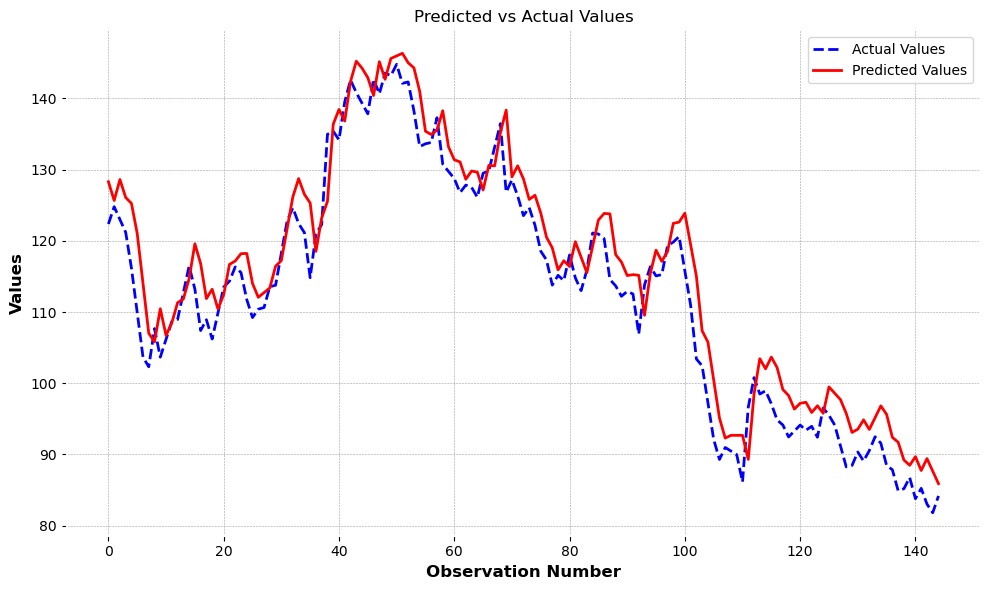

In [387]:
rnn1_predictions = model_rnn1.predict(X_test)
rnn1_predictions_rescaled = scaler.inverse_transform(rnn1_predictions)
rnn1_mse = mean_squared_error(y_test_scaled, rnn1_predictions_rescaled)
rnn1_mae = mean_absolute_error(y_test_scaled, rnn1_predictions_rescaled)
print(rnn1_mse)
print(rnn1_mae)
plot_predict(y_test_scaled, rnn1_predictions_rescaled, title='Predicted vs Actual Values')

In [388]:
model_rnn2 = build_custom_model(layer_type='RNN', input_shape=(30, 1), layer_sizes=[50], num_layers=3, dropout=0.3)
history1 = model_rnn2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
19/19 [==============================] - 1s 15ms/step - loss: 0.5894 - val_loss: 0.0962
Epoch 2/50
19/19 [==============================] - 0s 7ms/step - loss: 0.3985 - val_loss: 0.0279
Epoch 3/50
19/19 [==============================] - 0s 7ms/step - loss: 0.3905 - val_loss: 0.3403
Epoch 4/50
19/19 [==============================] - 0s 7ms/step - loss: 0.3407 - val_loss: 0.1131
Epoch 5/50
19/19 [==============================] - 0s 7ms/step - loss: 0.3515 - val_loss: 0.1902
Epoch 6/50
19/19 [==============================] - 0s 8ms/step - loss: 0.3305 - val_loss: 0.0169
Epoch 7/50
19/19 [==============================] - 0s 8ms/step - loss: 0.1832 - val_loss: 0.2182
Epoch 8/50
19/19 [==============================] - 0s 9ms/step - loss: 0.1771 - val_loss: 0.0533
Epoch 9/50
19/19 [==============================] - 0s 8ms/step - loss: 0.1471 - val_loss: 0.0213
Epoch 10/50
19/19 [==============================] - 0s 8ms/step - loss: 0.1147 - val_loss: 0.0099
Epoch 11/50
19/19 

5/5 [==============================] - 0s 3ms/step
90.23366143607194


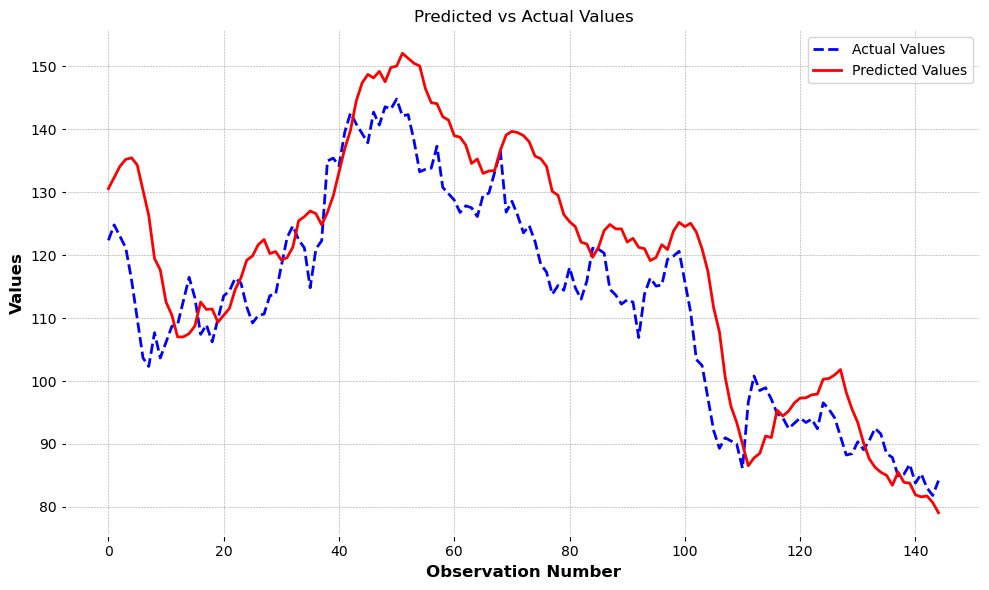

In [389]:
rnn2_predictions = model_rnn2.predict(X_test)
rnn2_predictions_rescaled = scaler.inverse_transform(rnn2_predictions)
rnn2_mse = mean_squared_error(y_test_scaled, rnn2_predictions_rescaled)
rnn2_mae = mean_absolute_error(y_test_scaled, rnn2_predictions_rescaled)
print(rnn2_mse)
plot_predict(y_test_scaled, rnn2_predictions_rescaled, title='Predicted vs Actual Values')

GRU

In [390]:
model_gru1 = build_custom_model(layer_type='GRU', input_shape=(30, 1), layer_sizes=[100], num_layers=1, dropout=0.2)
history1 = model_gru1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50


2024-10-01 14:34:55.703090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 14:34:55.703459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 14:34:55.704000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 1s 16ms/step - loss: 0.0656 - val_loss: 0.0329
Epoch 2/50
14/19 [=====================>........] - ETA: 0s - loss: 0.0165

2024-10-01 14:34:56.488721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 14:34:56.489220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 14:34:56.489747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 0s 9ms/step - loss: 0.0155 - val_loss: 0.0219
Epoch 3/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0081 - val_loss: 0.0150
Epoch 4/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0132
Epoch 5/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0084
Epoch 6/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0060
Epoch 7/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 8/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 9/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 10/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 11/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 12/50
19/19 [==========

5/5 [==============================] - 0s 2ms/step
25.66617373421161


2024-10-01 14:35:05.114431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 14:35:05.114985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 14:35:05.115561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

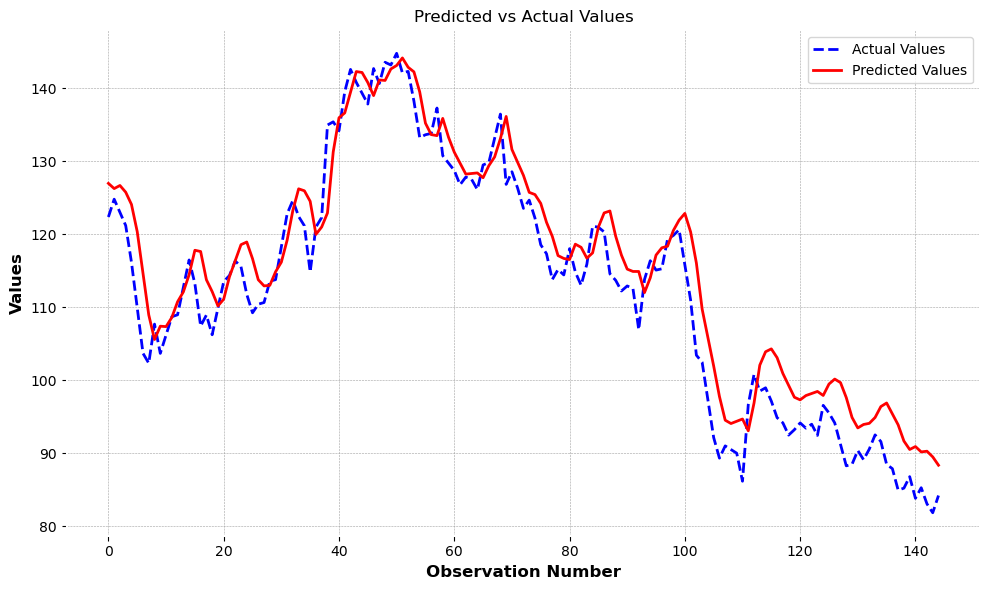

In [391]:
gru1_predictions = model_gru1.predict(X_test)
gru1_predictions_rescaled = scaler.inverse_transform(gru1_predictions)
gru1_mse = mean_squared_error(y_test_scaled, gru1_predictions_rescaled)
gru1_mae = mean_absolute_error(y_test_scaled, gru1_predictions_rescaled)
print(gru1_mse)
plot_predict(y_test_scaled, gru1_predictions_rescaled, title='Predicted vs Actual Values')

In [401]:
model_gru2 = build_custom_model(layer_type='GRU', input_shape=(30, 1), layer_sizes=[50], num_layers=3, dropout=0.3)
history1 = model_gru2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50


2024-10-01 19:25:13.053221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 19:25:13.054157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 19:25:13.054735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - ETA: 0s - loss: 0.0703

2024-10-01 19:25:15.101276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 19:25:15.101787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 19:25:15.102400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 2s 34ms/step - loss: 0.0703 - val_loss: 0.0143
Epoch 2/50
19/19 [==============================] - 0s 18ms/step - loss: 0.0436 - val_loss: 0.0623
Epoch 3/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0296 - val_loss: 0.0435
Epoch 4/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0213 - val_loss: 0.0241
Epoch 5/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0156 - val_loss: 0.0077
Epoch 6/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0123 - val_loss: 0.0038
Epoch 7/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0114 - val_loss: 0.0039
Epoch 8/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0122 - val_loss: 0.0052
Epoch 9/50
19/19 [==============================] - 0s 18ms/step - loss: 0.0117 - val_loss: 0.0059
Epoch 10/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0122 - val_loss: 0.0054
Epoch 11/50
19/19 [=

2024-10-01 19:25:31.736350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 19:25:31.736982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 19:25:31.737634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 0s 4ms/step
37.19668153786011


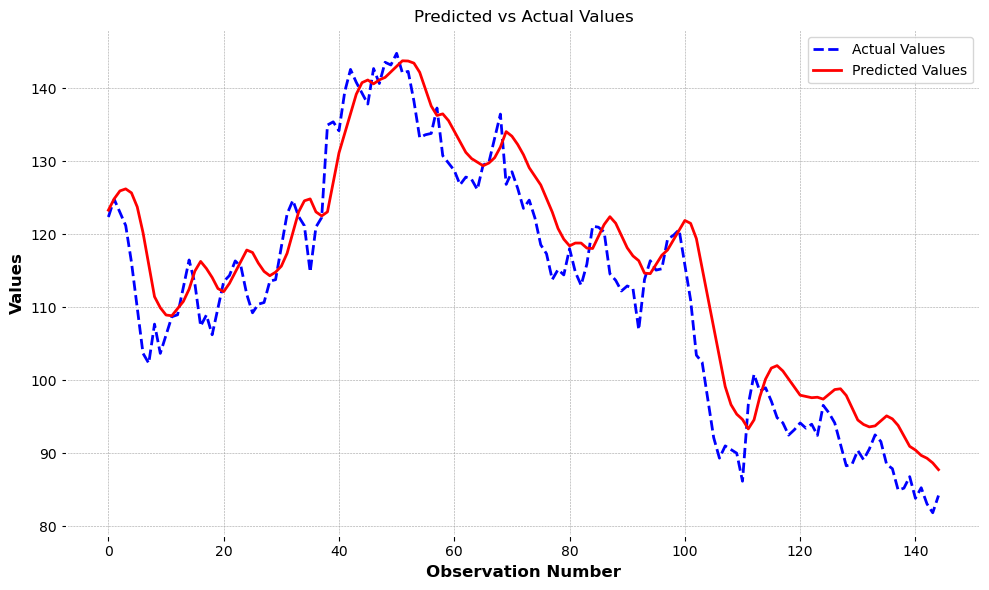

In [402]:
gru2_predictions = model_gru2.predict(X_test)
gru2_predictions_rescaled = scaler.inverse_transform(gru2_predictions)
gru2_mse = mean_squared_error(y_test_scaled, gru2_predictions_rescaled)
gru2_mae = mean_absolute_error(y_test_scaled, gru2_predictions_rescaled)
print(gru2_mse)
plot_predict(y_test_scaled, gru2_predictions_rescaled, title='Predicted vs Actual Values')

LSTM

In [408]:
model_lstm1 = build_custom_model(layer_type='LSTM', input_shape=(30, 1), layer_sizes=[200], num_layers=2, dropout=0.2)
history1 = model_lstm1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50


2024-10-01 19:35:27.657625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 19:35:27.658315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 19:35:27.658691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/19 [===========================>..] - ETA: 0s - loss: 0.0283

2024-10-01 19:35:29.652344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 19:35:29.652965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 19:35:29.653401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 2s 64ms/step - loss: 0.0282 - val_loss: 0.0089
Epoch 2/50
19/19 [==============================] - 1s 54ms/step - loss: 0.0121 - val_loss: 0.0130
Epoch 3/50
19/19 [==============================] - 1s 60ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 4/50
19/19 [==============================] - 1s 53ms/step - loss: 0.0139 - val_loss: 0.0100
Epoch 5/50
19/19 [==============================] - 1s 57ms/step - loss: 0.0148 - val_loss: 0.0108
Epoch 6/50
19/19 [==============================] - 1s 58ms/step - loss: 0.0164 - val_loss: 0.0111
Epoch 7/50
19/19 [==============================] - 1s 56ms/step - loss: 0.0185 - val_loss: 0.0122
Epoch 8/50
19/19 [==============================] - 1s 54ms/step - loss: 0.0208 - val_loss: 0.0154
Epoch 9/50
19/19 [==============================] - 1s 55ms/step - loss: 0.0277 - val_loss: 0.0189
Epoch 10/50
19/19 [==============================] - 1s 55ms/step - loss: 0.0315 - val_loss: 0.0239
Epoch 11/50
19/19 [=

1/5 [=====>........................] - ETA: 0s

2024-10-01 19:36:23.212667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 19:36:23.213349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 19:36:23.213977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 0s 14ms/step
37.921761336373464


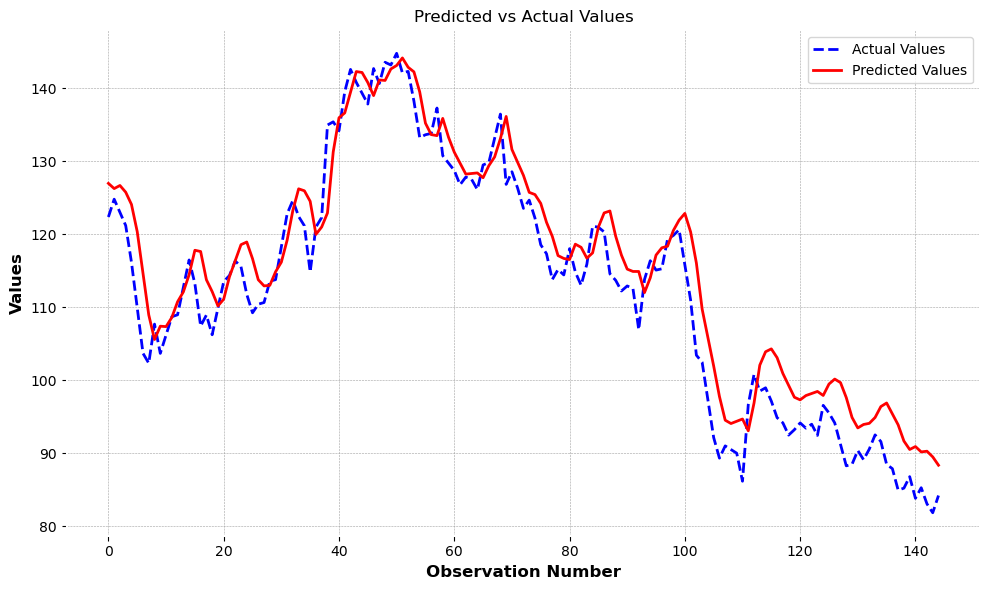

In [409]:
lstm1_predictions = model_lstm1.predict(X_test)
lstm1_predictions_rescaled = scaler.inverse_transform(lstm1_predictions)
lstm1_mse = mean_squared_error(y_test_scaled, lstm1_predictions_rescaled)
lstm1_mae = mean_absolute_error(y_test_scaled, lstm1_predictions_rescaled)
print(lstm1_mse)
plot_predict(y_test_scaled, gru1_predictions_rescaled, title='Predicted vs Actual Values')

In [410]:
model_lstm2 = build_custom_model(layer_type='LSTM', input_shape=(30, 1), layer_sizes=[50], num_layers=3, dropout=0.3)
history1 = model_lstm2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50


2024-10-01 19:36:23.600680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 19:36:23.601572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 19:36:23.602001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/19 [========================>.....] - ETA: 0s - loss: 0.0482

2024-10-01 19:36:25.632306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 19:36:25.633029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 19:36:25.633462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 2s 40ms/step - loss: 0.0479 - val_loss: 0.0289
Epoch 2/50
19/19 [==============================] - 0s 19ms/step - loss: 0.0204 - val_loss: 0.0121
Epoch 3/50
19/19 [==============================] - 0s 19ms/step - loss: 0.0326 - val_loss: 0.0146
Epoch 4/50
19/19 [==============================] - 0s 19ms/step - loss: 0.0492 - val_loss: 0.0425
Epoch 5/50
19/19 [==============================] - 0s 19ms/step - loss: 0.0451 - val_loss: 0.0541
Epoch 6/50
19/19 [==============================] - 0s 19ms/step - loss: 0.0250 - val_loss: 0.0300
Epoch 7/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0188 - val_loss: 0.0158
Epoch 8/50
19/19 [==============================] - 0s 19ms/step - loss: 0.0182 - val_loss: 0.0125
Epoch 9/50
19/19 [==============================] - 0s 19ms/step - loss: 0.0177 - val_loss: 0.0099
Epoch 10/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0201 - val_loss: 0.0143
Epoch 11/50
19/19 [=

2024-10-01 19:36:43.767739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-01 19:36:43.768404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-01 19:36:43.768918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 0s 4ms/step


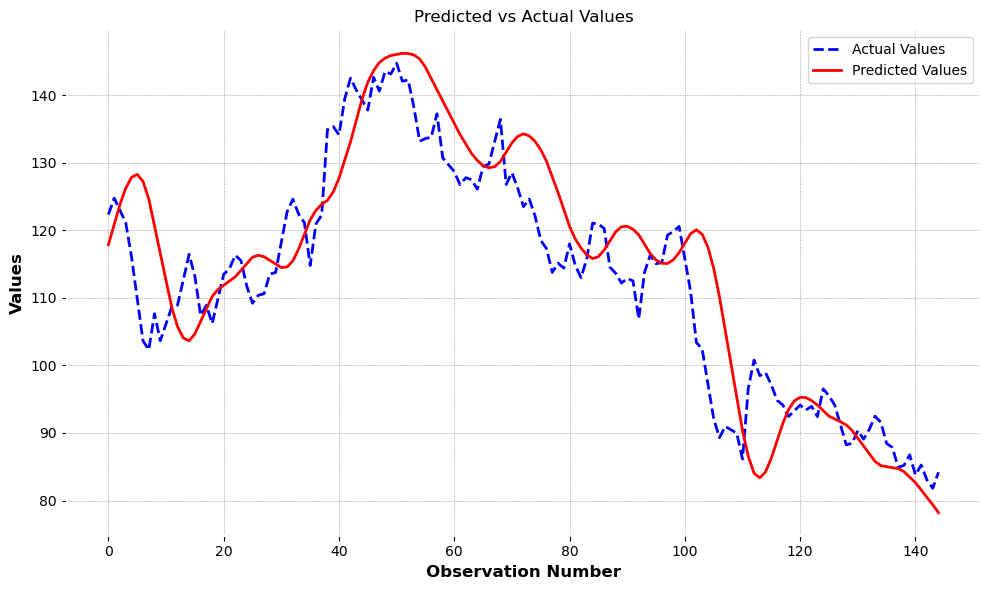

In [411]:
lstm2_predictions = model_lstm2.predict(X_test)
lstm2_predictions_rescaled = scaler.inverse_transform(lstm2_predictions)
lstm2_mse = mean_squared_error(y_test_scaled, lstm2_predictions_rescaled)
lstm2_mae = mean_absolute_error(y_test_scaled, lstm2_predictions_rescaled)
plot_predict(y_test_scaled, lstm2_predictions_rescaled, title='Predicted vs Actual Values')

## Compare

In [412]:
df_values = {
    'Model': [],
    'MSE': [],
    'MAE': []
}

# add value
df_values['Model'].append('RNN1')
df_values['MSE'].append(rnn1_mse)
df_values['MAE'].append(rnn1_mae)


df_values['Model'].append('RNN2')
df_values['MSE'].append(rnn2_mse)
df_values['MAE'].append(rnn2_mae)

df_values['Model'].append('GRU1')
df_values['MSE'].append(gru1_mse)
df_values['MAE'].append(gru1_mae)

df_values['Model'].append('GRU2')
df_values['MSE'].append(gru2_mse)
df_values['MAE'].append(gru2_mae)

df_values['Model'].append('LSTM1')
df_values['MSE'].append(lstm1_mse)
df_values['MAE'].append(lstm1_mae)

df_values['Model'].append('LSTM2')
df_values['MSE'].append(lstm2_mse)
df_values['MAE'].append(lstm2_mae)

# Convert to DataFrame
mse_df = pd.DataFrame(df_values)

# Save the DataFrame to CSV
mse_df.to_csv('mae_mse_values.csv', index=False)
mse_df


,Model,MSE,MAE
0,RNN1,23.258420,4.005665
1,RNN2,90.233661,7.737013
2,GRU1,25.666174,4.178811
3,GRU2,37.196682,4.925350
4,LSTM1,37.921761,4.774777
5,LSTM2,63.991469,6.100073
